# Self-Driving Car Engineering

## Convolutional Neural Network

## Traffic Sign Classifier

## Step 0: Load The Data

In [82]:
import numpy as np
import tensorflow as tf

# Load pickled data
import pickle

training_file = "./traffic-signs-data/train.p"
validation_file= "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [83]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples = ", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples = ", n_test)
print("Image data shape = ", image_shape)
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation examples =  4410
Number of testing examples =  12630
Image data shape =  (32, 32, 3)
Number of classes =  43


### Include an exploratory visualization of the dataset

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

(array([ 180., 1980., 2010., 1260., 1770., 1650.,  360., 1290., 1260.,
        1320., 1800., 1170., 1890., 1920.,  690.,  540.,  360.,  990.,
        1080.,  180.,  300.,  270.,  330.,  450.,  240., 1350.,  540.,
         210.,  480.,  240.,  390.,  690.,  210.,  599.,  360., 1080.,
         330.,  180., 1860.,  270.,  300.,  210.,  210.]),
 array([ 0.        ,  0.97674419,  1.95348837,  2.93023256,  3.90697674,
         4.88372093,  5.86046512,  6.8372093 ,  7.81395349,  8.79069767,
         9.76744186, 10.74418605, 11.72093023, 12.69767442, 13.6744186 ,
        14.65116279, 15.62790698, 16.60465116, 17.58139535, 18.55813953,
        19.53488372, 20.51162791, 21.48837209, 22.46511628, 23.44186047,
        24.41860465, 25.39534884, 26.37209302, 27.34883721, 28.3255814 ,
        29.30232558, 30.27906977, 31.25581395, 32.23255814, 33.20930233,
        34.18604651, 35.1627907 , 36.13953488, 37.11627907, 38.09302326,
        39.06976744, 40.04651163, 41.02325581, 42.        ]),
 <a list of

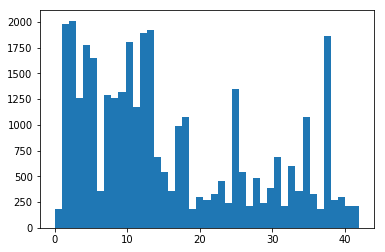

In [84]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# A histogram of the distribution of classes in the training data
plt.hist(y_train, bins=n_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test the model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). The LeNet-5 implementation is a solid starting point.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). 

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project.

In [85]:
### Preprocess the data
import cv2

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    gray_min = 0
    gray_max = 255
    
    return ( a + image_data * (b-a) / (gray_max - gray_min) )


def preprocess(data):
    processed = []
    for img in data:
        img = grayscale(img)
        img = normalize_grayscale(img)
        processed.append(img)
        
    return np.array(processed)

In [86]:
from numpy import newaxis

X_train = preprocess(X_train)
X_valid = preprocess(X_valid)
X_test = preprocess(X_test)

# grayscale removes the last axis for some reason
X_train = X_train[..., newaxis]
X_valid = X_valid[..., newaxis]
X_test = X_test[..., newaxis]

print(X_train.shape)

(34799, 32, 32, 1)


### Model Architecture

In [87]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0.0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x24
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 24), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(24))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x24. Output = 14x14x24
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x72
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 24, 72), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(72))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x72. Output = 5x5x72
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 3: Convolutional. Output = 3x3x96
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 72, 96), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(96))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation
    conv3 = tf.nn.relu(conv3)
    
    # Flatten. Input = 3x3x96. Output = 864
    fc0   = flatten(conv3)
    
    # Layer 4: Fully Connected. Input = 864. Output = 240
    fc1_W = tf.Variable(tf.truncated_normal(shape=(864, 240), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(240))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1    = tf.nn.relu(fc1)

    # Layer 5: Fully Connected. Input = 240. Output = 84
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(240, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2    = tf.nn.relu(fc2)

    # Layer 6: Fully Connected. Input = 84. Output = n_classes
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [88]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

## Training Pipeline

In [89]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [90]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [91]:
from sklearn.utils import shuffle

EPOCHS = 25
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    """
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        
    saver.save(sess, './model')
    print("Model saved")"""

Training...



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

## Restore the model

In [92]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print('Model restored')

INFO:tensorflow:Restoring parameters from .\model


NotFoundError: Key Variable_12 not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]

Caused by op 'save_2/RestoreV2', defined at:
  File "C:\Users\charej3\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\charej3\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\charej3\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-90-c5da69dcb222>", line 3, in <module>
    saver = tf.train.Saver()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1338, in __init__
    self.build()
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1546, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\charej3\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key Variable_12 not found in checkpoint
	 [[Node: save_2/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_2/Const_0_0, save_2/RestoreV2/tensor_names, save_2/RestoreV2/shape_and_slices)]]


### Load and Output the Images

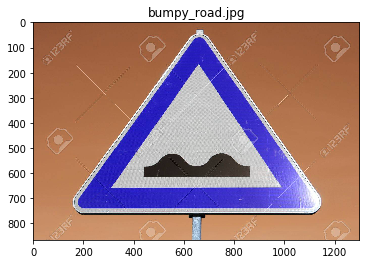

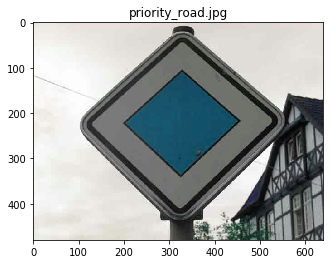

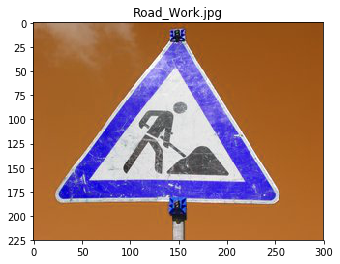

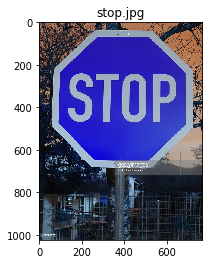

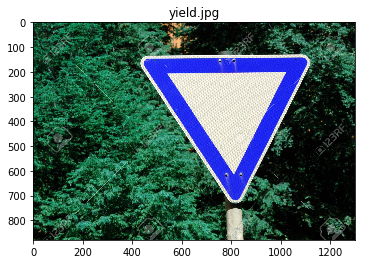

In [93]:
import os
import matplotlib.image as mpimg

# output five test images
for img in os.listdir("test/"):
    plt.figure()
    plt.imshow(cv2.imread("./test/" + img))
    plt.title(img)

### Predict the Sign Type for Each Image

In [94]:
processed_test = []
test_names = []

# preprocess
for file in os.listdir("test/"):
    img = cv2.resize(cv2.imread("./test/" + file), (32,32))
    img = grayscale(img)          # same preprocessing as the training data
    img = normalize_grayscale(img)
    print(img.shape)
    processed_test.append(img)
    test_names.append(file)
    
processed_test = np.array(processed_test)
processed_test = processed_test[..., newaxis]
test_labels = [22,12,25,14,13]

print(processed_test.shape)

# run through the model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_accuracy = evaluate(processed_test, test_labels)
    print("Accuracy: {}".format(test_accuracy))

(32, 32)
(32, 32)
(32, 32)
(32, 32)
(32, 32)
(5, 32, 32, 1)
Accuracy: 0.0


### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [97]:
# get all the possible classes
import csv
labels = []

with open('signnames.csv', 'r') as signnames:
    read = csv.reader(signnames, delimiter=',')
    for row in read:
        labels += [row[1]]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    test_logits = sess.run(logits, feed_dict={x: processed_test})
    softmax_logits = tf.nn.softmax(test_logits)
    top_3 = sess.run(tf.nn.top_k(softmax_logits, k=3))
    
    for x in range(len(processed_test)):
        print("{0}:".format(test_names[x]))
        for y in range(3):
            print("{:s}: {:.2f}%".format(labels[top_3[1][x][y]], top_3[0][x][y]*100))
        print()

bumpy_road.jpg:
Road narrows on the right: 9.96%
General caution: 5.43%
Bumpy road: 5.35%

priority_road.jpg:
Road narrows on the right: 5.39%
Bumpy road: 5.30%
General caution: 4.60%

Road_Work.jpg:
Road narrows on the right: 6.70%
Dangerous curve to the right: 6.21%
General caution: 5.04%

stop.jpg:
Road narrows on the right: 6.27%
Dangerous curve to the right: 5.92%
Speed limit (30km/h): 4.65%

yield.jpg:
Dangerous curve to the right: 8.42%
General caution: 6.55%
Road narrows on the right: 6.29%



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.